In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("diabetes.csv")

<Axes: >

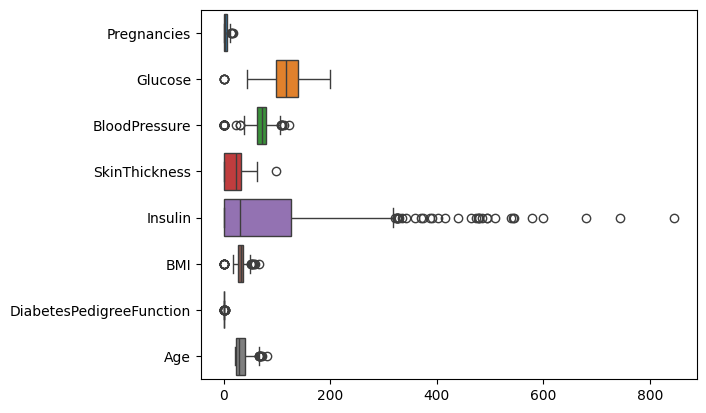

In [3]:
#Quick Visualisation of all data features
sns.boxplot(data.iloc[:, :8], legend="auto", orient="y")

<Axes: >

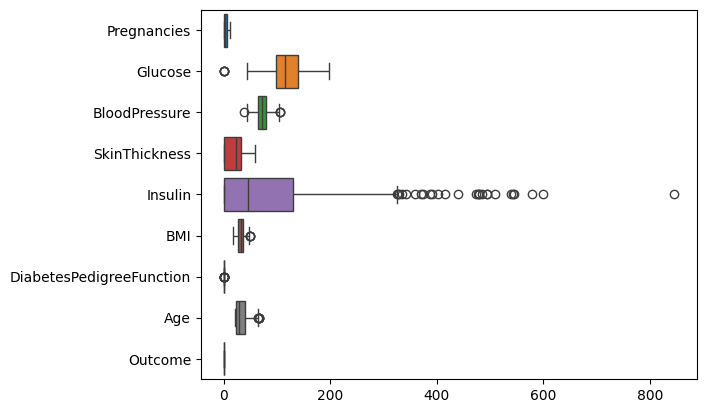

In [4]:
data_cleaned = data.copy()
outliers = set()

#Loop used to drop datapoints that contain outliers from features that arent explicitly listed
for label in data_cleaned.columns:
    if label not in ["Insulin", "Glucose", "Outcome"]:
        Q1 = data_cleaned[label].quantile(0.25)
        Q3 = data_cleaned[label].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR

        upper_array = data_cleaned.index[data_cleaned[label] >= upper].tolist()
        lower_array = data_cleaned.index[data_cleaned[label] <= lower].tolist()

        outliers.update(upper_array)
        outliers.update(lower_array)

data_cleaned.drop(index=outliers, inplace=True)

sns.boxplot(data=data_cleaned, orient="y", legend="auto")

In [5]:
print(data_cleaned.shape)
working_data = np.array(data_cleaned)
transformer = StandardScaler().fit(working_data)
scaled_data = transformer.transform(np.array(working_data))

(675, 9)


In [6]:
y = np.array(data_cleaned.iloc[:, 8:])
X = scaled_data[:, :8]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [7]:
# Arrays converted into float32 tensors due to scaling
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [8]:
def train_model(model, X_train, y_train, criterion, optimizer, epochs=100):
    """
    Trains the model object for a an amount of epochs using the specified 
    optimizer and loss criterion.

    Outputs the epoch progress in lots of 10 and the calculated loss, as well
    as updating the model object with the appropriate weights. 

    :param model: Model to evaluate
    :param X_train: Input vectors for training
    :param y_train: Real class for vector
    :param criterion: torch.nn loss function
    :param optimizer: torch.optim optimizer function
    :param epoch: The amount of times the model is exposed to the dataset
    """
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the test data against the specified model without altering the 
    model object.

    Outputs the percentage accuracy of the predicted labels against the true 
    labels.

    :param model: Model to evaluate
    :param X_test: Input vectors to predict class
    :param y_test: Real class for vector
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs >= 0.5).float()
        accuracy = (predicted.eq(y_test).sum().item()) / y_test.shape[0]
        print(f'Accuracy: {accuracy * 100:.2f}%')

def model_confusion_matrix(model, X_test, y_test):
    """
    Plots a confusion matrix by running the classifier against the test dataset.
    
    Outputs a seaborn heatmap plot.

    :param model: Model to evaluate
    :param X_test: Input vectors to predict class
    :param y_test: Real class for vector
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs >= 0.5)

        cm = confusion_matrix(y_test, predicted, normalize="all")

        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", 
                    xticklabels=['Negative', 'Positive'], 
                    yticklabels=['Negative', 'Positive'])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

In [9]:
class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_size):
        super(SingleLayerPerceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# using standard criterion, loss and optimizer
input_size = X_train.shape[1]
slp_model = SingleLayerPerceptron(input_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(slp_model.parameters(), lr=0.01)

Epoch [10/100], Loss: 0.6380
Epoch [20/100], Loss: 0.6293
Epoch [30/100], Loss: 0.6212
Epoch [40/100], Loss: 0.6136
Epoch [50/100], Loss: 0.6066
Epoch [60/100], Loss: 0.6000
Epoch [70/100], Loss: 0.5938
Epoch [80/100], Loss: 0.5880
Epoch [90/100], Loss: 0.5826
Epoch [100/100], Loss: 0.5775
Accuracy: 66.67%


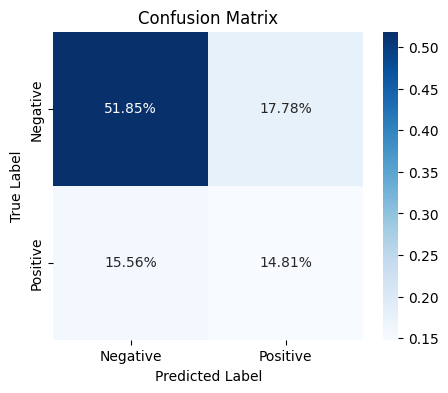

In [10]:
train_model(slp_model, X_train, y_train, criterion, optimizer)
evaluate_model(slp_model, X_test, y_test)
model_confusion_matrix(slp_model, X_test, y_test)

In [11]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.sigmoid(self.fc2(x))

# using standard criterion, loss and optimizer
input_size = X_train.shape[1]
hidden_size = 32  # customizable quantity of hidden layers
mlp_model = MultiLayerPerceptron(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01)

Epoch [10/100], Loss: 0.6480
Epoch [20/100], Loss: 0.6385
Epoch [30/100], Loss: 0.6299
Epoch [40/100], Loss: 0.6221
Epoch [50/100], Loss: 0.6150
Epoch [60/100], Loss: 0.6085
Epoch [70/100], Loss: 0.6025
Epoch [80/100], Loss: 0.5969
Epoch [90/100], Loss: 0.5917
Epoch [100/100], Loss: 0.5868
Accuracy: 69.63%


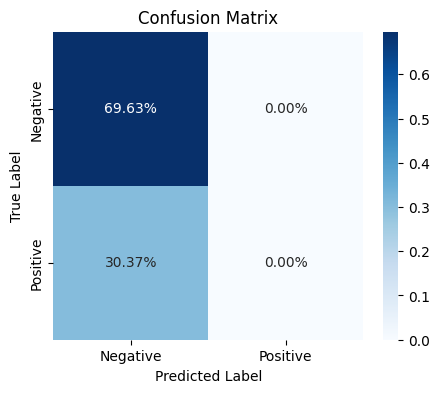

In [12]:
train_model(mlp_model, X_train, y_train, criterion, optimizer)
evaluate_model(mlp_model, X_test, y_test)
model_confusion_matrix(mlp_model, X_test, y_test)

In [13]:
class OptimisedMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(OptimisedMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return self.sigmoid(x)

# Using a  more complicated model, standard criterion and modern optimizer
input_size = X_train.shape[1]
hidden_size = 256
optimised_model = OptimisedMLP(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(optimised_model.parameters(), lr=0.001)

Epoch [10/100], Loss: 0.4559
Epoch [20/100], Loss: 0.4037
Epoch [30/100], Loss: 0.3814
Epoch [40/100], Loss: 0.3600
Epoch [50/100], Loss: 0.3421
Epoch [60/100], Loss: 0.3196
Epoch [70/100], Loss: 0.2929
Epoch [80/100], Loss: 0.2713
Epoch [90/100], Loss: 0.2396
Epoch [100/100], Loss: 0.2114
Accuracy: 82.96%


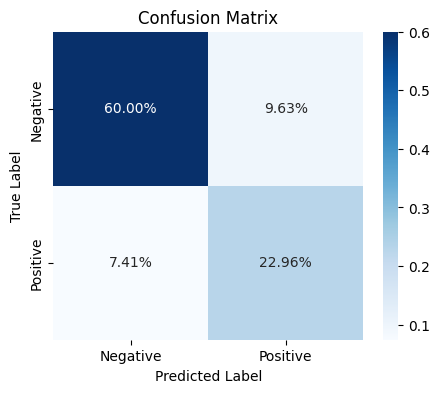

In [14]:
train_model(optimised_model, X_train, y_train, criterion, optimizer)
evaluate_model(optimised_model, X_test, y_test)
model_confusion_matrix(optimised_model, X_test, y_test)